# Check training model

This notebook will examine the trained model to see if it learned patterns of the input data. Specifically this notebook will look at:

1. Is there any structure in the data or just noise?
2. Does our latent space capture the clusters in our input data? Are there samples that we know should cluster together? Do we find those in the input and encoded data?
3. Do simulated samples, looks similar to the input data?

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import glob

# import umap
import pandas as pd
from keras.models import load_model
from sklearn.decomposition import PCA
from plotnine import (
    ggplot,
    labs,
    geom_line,
    geom_point,
    geom_errorbar,
    aes,
    ggsave,
    theme_bw,
    theme,
    xlim,
    ylim,
    facet_wrap,
    scale_color_manual,
    guides,
    guide_legend,
    element_blank,
    element_text,
    element_rect,
    element_line,
    coords,
)
from cm_modules import paths
from ponyo import utils, simulate_expression_data

random_state = 123

Using TensorFlow backend.


In [2]:
base_dir = os.path.abspath(os.path.join(os.getcwd(), "../"))

# Read in config variables
config_filename = os.path.abspath(
    os.path.join(base_dir, "test_vae_training", "config_current_vae.tsv")
)

params = utils.read_config(config_filename)

dataset_name = params["dataset_name"]
NN_architecture = params["NN_architecture"]
normalized_compendium_filename = params["normalized_compendium_filename"]

NN_dir = os.path.join(base_dir, dataset_name, "models", NN_architecture)

In [3]:
# Import normalized data
normalized_compendium = pd.read_csv(
    normalized_compendium_filename, sep="\t", index_col=0, header=0
)

In [4]:
normalized_compendium.head()

,Bacteria Actinobacteriota Actinobacteria Bifidobacteriales Bifidobacteriaceae Bifidobacterium,Bacteria Bacteroidota Bacteroidia Bacteroidales Bacteroidaceae Bacteroides,Bacteria Actinobacteriota Coriobacteriia Coriobacteriales Coriobacteriaceae Collinsella,Bacteria Firmicutes Clostridia Lachnospirales Lachnospiraceae Agathobacter,Bacteria Firmicutes Negativicutes Veillonellales-Selenomonadales Selenomonadaceae Megamonas,Bacteria Firmicutes Clostridia Lachnospirales Lachnospiraceae Blautia,Bacteria Firmicutes Clostridia Oscillospirales Ruminococcaceae Faecalibacterium,Bacteria Firmicutes Clostridia Lachnospirales Lachnospiraceae Anaerostipes,Bacteria Bacteroidota Bacteroidia Bacteroidales Prevotellaceae Prevotella,Bacteria Firmicutes Bacilli Lactobacillales Streptococcaceae Streptococcus,...,Bacteria Actinobacteriota Acidimicrobiia Microtrichales Ilumatobacteraceae NA,Bacteria Verrucomicrobiota Verrucomicrobiae Pedosphaerales Pedosphaeraceae ADurb.Bin063-1,Bacteria Proteobacteria Alphaproteobacteria Caulobacterales Caulobacteraceae PMMR1,Bacteria Bacteroidota Bacteroidia Flavobacteriales Cryomorphaceae NA,Bacteria Bacteroidota Bacteroidia Flavobacteriales Flavobacteriaceae Pseudofulvibacter,Bacteria Proteobacteria Alphaproteobacteria Rickettsiales Rickettsiaceae NA,Bacteria Bacteroidota Bacteroidia Flavobacteriales Flavobacteriaceae Gelidibacter,Bacteria Proteobacteria Gammaproteobacteria Burkholderiales Comamonadaceae Ideonella,Bacteria Proteobacteria Alphaproteobacteria Rhizobiales Xanthobacteraceae Rhodoplanes,Bacteria Proteobacteria Alphaproteobacteria Sphingomonadales Sphingomonadaceae Rhizorhapis
PRJDB5310_DRR077057,0.001496,0.000948,0.000000,0.000000,0.000000,0.000000,0.004278,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PRJDB5310_DRR077058,0.001169,0.000702,0.000000,0.000000,0.000000,0.000046,0.002383,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PRJDB5310_DRR077059,0.000000,0.000572,0.000000,0.001081,0.000000,0.001694,0.002962,0.001032,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PRJDB5310_DRR077060,0.003358,0.000000,0.004034,0.000877,0.000000,0.000561,0.001506,0.000465,0.0,0.000620,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PRJDB5310_DRR077061,0.000188,0.000751,0.001546,0.000529,0.003158,0.000671,0.001037,0.001376,0.0,0.000112,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# Drop outliers found manually
samples_to_drop = [
    "PRJEB34610_ERR3561806",
    "PRJEB34610_ERR3561830",
    "PRJNA297268_SRR2568180",
]
normalized_compendium = normalized_compendium.drop(samples_to_drop)

### Plot umap of normalized data

In [6]:
pca = PCA(n_components=2)

In [7]:
# Get and save PCA model
model = pca.fit(normalized_compendium)
# model = umap.UMAP(random_state=random_state).fit(normalized_compendium)

compendium_PCAencoded = model.transform(normalized_compendium)

compendium_PCAencoded_df = pd.DataFrame(
    data=compendium_PCAencoded, index=normalized_compendium.index, columns=["1", "2"]
)

/home/alexandra/anaconda3/envs/common_microbe/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


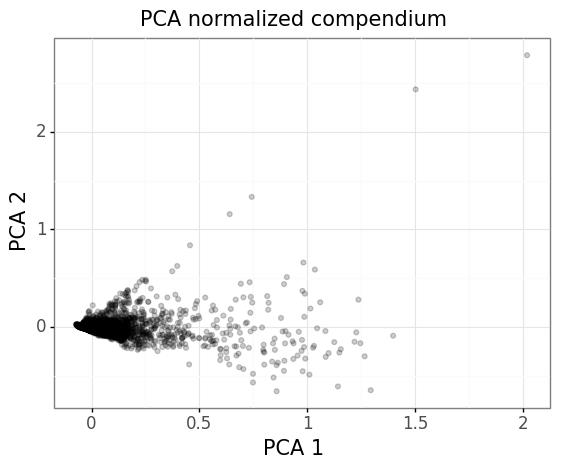

<ggplot: (8745001603085)>


In [8]:
# Plot
fig = ggplot(compendium_PCAencoded_df, aes(x="1", y="2"))
fig += geom_point(alpha=0.2)
fig += labs(x="PCA 1", y="PCA 2", title="PCA normalized compendium")
fig += theme_bw()
fig += theme(
    legend_title_align="center",
    plot_background=element_rect(fill="white"),
    legend_key=element_rect(fill="white", colour="white"),
    legend_title=element_text(family="sans-serif", size=15),
    legend_text=element_text(family="sans-serif", size=12),
    plot_title=element_text(family="sans-serif", size=15),
    axis_text=element_text(family="sans-serif", size=12),
    axis_title=element_text(family="sans-serif", size=15),
)
fig += guides(colour=guide_legend(override_aes={"alpha": 1}))

print(fig)

### Plot encoded data

In [9]:
# Load VAE models
model_encoder_file = glob.glob(os.path.join(NN_dir, "*_encoder_model.h5"))[0]

weights_encoder_file = glob.glob(os.path.join(NN_dir, "*_encoder_weights.h5"))[0]

model_decoder_file = glob.glob(os.path.join(NN_dir, "*_decoder_model.h5"))[0]

weights_decoder_file = glob.glob(os.path.join(NN_dir, "*_decoder_weights.h5"))[0]

# Load saved models
loaded_model = load_model(model_encoder_file)
loaded_decode_model = load_model(model_decoder_file)

loaded_model.load_weights(weights_encoder_file)
loaded_decode_model.load_weights(weights_decoder_file)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


/home/alexandra/anaconda3/envs/common_microbe/lib/python3.7/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [10]:
# Encode normalized compendium into latent space
compendium_encoded = loaded_model.predict_on_batch(normalized_compendium)

compendium_encoded_df = pd.DataFrame(
    data=compendium_encoded, index=normalized_compendium.index
)

In [11]:
# Get and save PCA model
model = pca.fit(compendium_encoded_df)
# model = umap.UMAP(random_state=random_state).fit(compendium_encoded_df)

latent_compendium_PCAencoded = model.transform(compendium_encoded_df)

latent_compendium_PCAencoded_df = pd.DataFrame(
    data=latent_compendium_PCAencoded,
    index=compendium_encoded_df.index,
    columns=["1", "2"],
)

/home/alexandra/anaconda3/envs/common_microbe/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


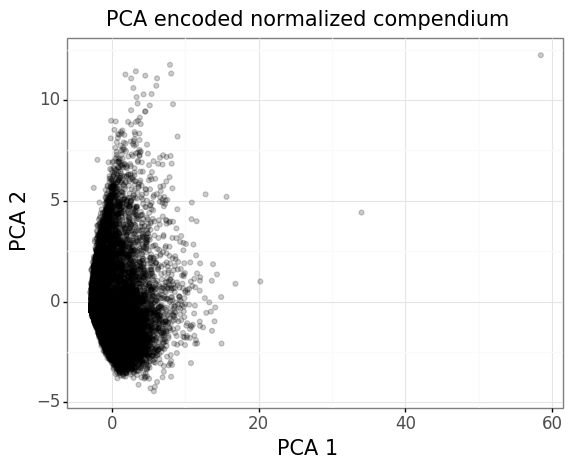

<ggplot: (8745002131229)>


In [12]:
# Plot umap of encoded data
fig = ggplot(latent_compendium_PCAencoded_df, aes(x="1", y="2"))
fig += geom_point(alpha=0.2)
fig += labs(x="PCA 1", y="PCA 2", title="PCA encoded normalized compendium")
fig += theme_bw()
fig += theme(
    legend_title_align="center",
    plot_background=element_rect(fill="white"),
    legend_key=element_rect(fill="white", colour="white"),
    legend_title=element_text(family="sans-serif", size=15),
    legend_text=element_text(family="sans-serif", size=12),
    plot_title=element_text(family="sans-serif", size=15),
    axis_text=element_text(family="sans-serif", size=12),
    axis_title=element_text(family="sans-serif", size=15),
)
fig += guides(colour=guide_legend(override_aes={"alpha": 1}))

print(fig)

## Simulate vs real data

Here we want to make sure that the distribution of the simulated data looks similar to the real data -- i.e. the sparsity is similar.

In [13]:
simulated_data = simulate_expression_data.run_sample_simulation(
    loaded_model, loaded_decode_model, normalized_compendium, 5
)

Return: simulated gene expression data containing 5 samples and 1232 genes


In [14]:
simulated_data.head()

,0,1,2,3,4,5,6,7,8,9,...,1222,1223,1224,1225,1226,1227,1228,1229,1230,1231
0,0.005350,0.001952,0.004221,0.002513,0.002103,0.001324,0.007538,0.001608,0.005076,0.001648,...,2.086163e-07,1.788139e-07,1.788139e-07,1.788139e-07,5.960464e-08,0.000002,3.278255e-07,1.370907e-06,5.960464e-08,2.980232e-08
1,0.016511,0.019836,0.013476,0.012053,0.013745,0.015411,0.042826,0.024478,0.001346,0.007852,...,3.337860e-05,2.524257e-05,2.235174e-05,1.060963e-05,2.092123e-05,0.000324,3.316998e-05,3.069937e-04,6.893277e-05,1.865625e-05
2,0.005449,0.008470,0.002524,0.003102,0.001962,0.005114,0.013021,0.006331,0.000833,0.003568,...,1.490116e-07,5.960464e-08,1.192093e-07,1.937151e-06,2.384186e-07,0.000000,8.940697e-08,7.450581e-07,6.854534e-06,2.980232e-08
3,0.014910,0.005776,0.006172,0.004380,0.003638,0.004320,0.010027,0.005281,0.004769,0.012404,...,1.305342e-05,1.323223e-05,1.081824e-05,1.385510e-04,6.705523e-06,0.000007,1.356006e-05,1.149774e-04,1.296103e-04,1.311302e-05
4,0.005015,0.018423,0.005216,0.004925,0.003148,0.003738,0.023402,0.006887,0.006094,0.002622,...,6.923079e-05,9.241700e-05,6.872416e-05,1.486808e-03,1.471043e-04,0.000138,7.036328e-05,4.282594e-04,1.659989e-05,4.193187e-05


In [17]:
# How sparse is this data matrix?
# How many 0s across the entire matrix?
num_zeros = (simulated_data == 0).sum().sum()
total = simulated_data.shape[0] * simulated_data.shape[1]
num_zeros / total

0.041233766233766234

In [20]:
# How lowly expressed is this data matrix?
num_low = (simulated_data < 0.1).sum().sum()
num_low / total

1.0

**Takeaways:**
* Latent representation captures the distribution of the input dataset, which is mainly composed of a single large cluster.
* The latent space compresses the spreading seen in the input dataset, as previously seen
* The simulated data, generated by randomly sampling from the latent space, is generating all lowly expressed microbes (i.e. all expression is below 0.1, but none are 0), which makes sense given the dominant signal in the data are these 0 counts